# SCS 3546 Deep Learning 

# Module 09: Deep Generative Models
***


## Learning Outcomes

By the end of this module, you will:

- Understand the core concepts behind Generative Adversarial Networks. 
- Know common difficulties when training GANs and techniques to mitigate them. 
- Be able to implement a basic GAN in Tensorflow.
- Be familiar with more advanced GAN architectures including CycleGAN and StyleGAN 
- Be familiar with Fully Visible Belief Nets (FVBN)


## Topics
- Generative Adversarial Networks (GAN)
- Problems when Training GANs
- GAN Architectures
- Fully Visible Belief Nets


## Introduction
In Module 8 we introduced the concept of generative models and provided a taxonomic categorization of them based on their characteristics such as the explicit vs. implicit density estimation:

<figure>
      <center><img src="https://drive.google.com/uc?id=189VpVee8ASwJGHv6TRLQpENWbu-oN-L5" ></center>
    <figcaption>
        <center>[<b>Image credit:</b> Goodfellow, I. (2016), Generative Adversarial Networks - NIPS 2016 tutorial. </center><center>Retrieved from https://www.youtube.com/watch?v=HGYYEUSm-0Q ]</center></center></figcaption>
</figure>

We also introduced VAEs as a generative model that optimizes an intractable explicit function $p_{\phi}(z|x)$ and due to this intractability we defined a (tractable) density function $q_{\theta}(z|x)$ that approximated the density of the original. Finally we optimized the original data likelihood by optimizing its lower bound based on $q_{\theta}(z|x)$.

In this module we will see two other examples of generative models that have found a great deal of success in the past few years. First we will talk about the Implicit class and arguably one of the most active research areas of generative models: **Generative Adversarial Networks (GAN)**. Then we will move on to another model from the explicit family **Fully Visible Belief Nets (FVBN)**, that have tractable density.

## Generative Adversarial Networks (GAN)
We know that if we had access to the true data distribution $P_{data}(x)$ we could sample from that distribution in order to generate new samples, however there is no direct way to do this as typically this distribution is complex and high-dimensional. What if we could instead sample from a random noise (e.g. Normal distribution) and then learn to transform that to $P_{data}(x)$. Neural networks are a prime candidate to capture functions with high complexity and we can use them to model this transformation. This is exactly what <font color='#c92d39'>**Generative Adversarial Networks (GANs)**</font> do. They train a network called a **Generator** along with second network, called the **Discriminator**, in a game theoretic way. Going back to our image generation example:

- The Generator network ($G$) produces synthetic images from randomly sampled latent vectors, nd tries to fool the discriminator in thinking that the generated images are real, meaning that they are taken from $P_{data}$, and
- The Discriminator network ($D$), tries to differentiate between real ($x\sim P_{data}$) and fake images.

This concept is captured in the image below:
<center><img src="https://drive.google.com/uc?id=1K61laUD12Jak8sQ3twLZTrXR4Gu7PPUn" ></center>


Random noise is fed into the Generator that transforms it into a "fake image". The Discriminator is fed and equal number of training set images ($p_{data}(x)$) and the fake images coming from the Generator, and it has to tell them apart. The idea behind a GAN is to train both of these networks alternatively to do the best they can in generating and discriminating images. The intuition is that by improving one of these networks, in this game theoretic manner, the other network has to do a better job to win the game, and that in turn improves its performance and this loop continues.

<div class="alert alert-block alert-warning"><b>The math under the hood:</b> Let's formalize the above notion and construct the two loss functions for the alternating training phases. The real images $x$ are sampled from $x\sim p_{data}$. The fake images are sampled from a simpler distribution $z\sim p(z)$, such as a unit Gaussian, and are then transformed by the Generator to look like real images: $G(z)$. Imagine that we are the discriminator. What we want is to maximize our likelihood of being able to identify real images: $0\le D(x)\le1$. At the same time, we want to minimize our likelihood of mistaking a fake image $D(G(z))$. In other words we want $D(x)$ to be closer to 1 and $D(G(z))$ be closer to 0. More importantly, we want to be able to do that for *all* real and fake images. So in a sense we want to increase the expectation of our discriminative ability over all samples, real or fake: </p>

$$
\mathbb{E}_{x \sim p_{d a t a}} \log D_{\theta_{d}}(x)+\mathbb{E}_{z \sim p(z)} \log \left(1-D_{\theta_{d}}\left(G_{\theta_{g}}(z)\right)\right)
$$


<p>Being the discriminator, the first term captures the expectation of us being able to identify real samples, taken from $p_{data}(x)$. For the fake images, we want to minimize $D(G(z))$, by bringing it as close as possible to 0, which is similar to bringing $1 - D(G(z))$ closer to 1. Notice that we have replaced likelihood with log-likelihood in the above formulation. </p>

<p>The $\theta_d$ and $\theta_g$ are the parameters of the discriminator and the generator (in that order) which we would like to learn. The discriminator's winning strategy is to set $\theta_d$ in order to maximize the above formula. However, the generator wants the opposite: It wants to sabotage discriminator's win by setting its own parameters $\theta_g$ in order to minimize the above formula. The overall objective function can be expressed as the following minmax optimization problem:</p>

$$
\min _{\theta_{g}} \max _{\theta_{d}}\left[\mathbb{E}_{x \sim p_{d a t a}} \log D_{\theta_{d}}(x)+\mathbb{E}_{z \sim p(z)} \log \left(1-D_{\theta_{d}}\left(G_{\theta_{g}}(z)\right)\right)\right]
$$


<br>
<p>We solve this problem with a two-phase minibatch training step that alternatively trains the discriminator and the generator with these loss functions:</p>

<p>
- **Gradient Ascent** using Generator's loss function: 

$$
\min _{\theta_{g}} \mathbb{E}_{z \sim p(z)} \log \left(1-D_{\theta_{d}}\left(G_{\theta_{g}}(z)\right)\right)
$$

</p>
<p>
- **Gradient Descent** using Discriminator's loss function: 

$$
\max _{\theta_{d}}\left[\mathbb{E}_{x \sim p_{\text {data }}} \log D_{\theta_{d}}(x)+\mathbb{E}_{z \sim p(z)} \log \left(1-D_{\theta_{d}}\left(G_{\theta_{g}}(z)\right)\right)\right]
$$

</p>


</div>

In the first step, we feed the discriminator equal numbers of real images and synthetic images produced by the generator, which are given class labels of 1 and 0 respectively. Then we perform backpropagation on only the discriminator to update its weights. In the second step, we freeze the weights of the discriminator, pass it fake images from the generator, but this time with a training label of 1 (we want to trick the discriminator into thinking they are real), and then we perform back-propagation again, this time passing the gradients onto the generator to update the generator's weights. 

### Vanila GAN: Demo 

Now that we have got the theory out of the way, let's build a GAN in Tensorflow. Following the advice of the co-inventor of GANs, __[Ian Goodfellow](https://arxiv.org/pdf/1406.2661.pdf)__, we will move away from the regular MNIST dataset and use the __[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist#get-the-data)__. Fashion-MNIST is a set of $28\times 28$ gray-scale images of 10 different classes of clothing items. This dataset is considered a harder dataset than regular MNIST, while still being simple enough for benchmarking and proof of concept purposes. Feel free to change the dataset back to MNIST, in order to compare the samples generated by GAN with those of the VAE's and Autoencoders of Module 8.

Below is code to build and train a simple GAN. [Here](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) you can find the source repository. 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras


(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            z = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(z)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

Output hidden; open in https://colab.research.google.com to view.

### Issues with GANs:

The alternative training of the generator and discriminator in GANs is not an easy task. It is extremely sensitive to hyper-parameters and under many conditions it might not converge to something meaningful or not converge at all. In this section we briefly discuss some of the issues with the standard GAN. Many varieties of GANs have been proposed over the last few years that aim to resolve some of these issues. We will discuss a few of them in the next section. However, detailed discussion of these methods is beyond the scope of this module. The __[GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo)__ on GitHub maintains a rather comprehensive list of GANs that can be used as a reference.

Here are some of the problems:
- **Slow Initial Training Rate**: The generator starts by producing random noise, which is easy for the discriminator to spot. The discriminator has low incentive to improve, and as a result it learns very little about the real data. This means there is also very little information flow about what real images look like from the backpropagated gradients to the generator, so the generator fails to learn as well. 

- **Mode Collapse:** Mode collapse happens when the generator finds an optimal point and generates the same image over and over. A full collapse is rare but partial collapse is very common. In partial collapse, many of the generated samples look very similar. There has been a lot of work in penalizing the generator if it produces images with low diversity. __[Minibatch discrimination](https://arxiv.org/pdf/1606.03498)__ is one such technique. The argument here is that because the discriminator examines each sample independently, there is no mechanism for it to judge on the diversity of the generated images and hence no way for it to force the generator to produce more dissimilar instances. Minibatch discrimination mitigates this by allowing the discriminator to examine a batch of samples at a time and calculate a distance measure between them that can aid its decision in classifying a sample as real or fake. __[Wasserstein GAN](https://arxiv.org/pdf/1701.07875)__ is another work that results in diversification of generated samples.

- **Non-convergance:** Using gradient descent in order to train two networks in an adversarial way might lead to a case where the scores for the two players oscillate back and forth without any overall convergence towards a goal state.


### Deep convolutional generative adversarial networks (DCGAN)
__[Deep convolutional generative adversarial networks (DCGANs)](https://arxiv.org/pdf/1511.06434.pdf)__ impose a set of constraints on the architecture of the Convolutional GANs to stabilize their training.

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers

In their paper, Radford et al. showed that they can use the generator to generate new (unmemoized) samples, but they showed that the discriminator show high representation learning capacity and can be used as a feature extractor for other supervised learning classifiers. You can find the code example [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb). The following figure shows the architecture of a DCGAN:

<figure>
    <img src="https://drive.google.com/uc?id=1JEMa4oq0jrcboLAPZhdUVrKF_NoxcVOH" >
    <figcaption><center>[<b>Image credit:</b> Radford, A., Metz, L., & Chintala, S. (2015). </center><center>Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.</center></figcaption>
</figure>

<p>The input is a 100 dimensional uniform distribution that is passed through a series of four fractionally-strided convolutions and finally then converted to a 64 × 64 pixel image. No fully-connected or pooling layers are used. Here are some samples that are generated using the trained generator:</p>

<p>
<figure>
    <center><img src="https://drive.google.com/uc?id=1mjAE-A8pOUxCMjazjyFcNzqF5VJ8jUTL" ></center>
    <figcaption><center>Generated bedrooms after five epochs of training.</center><center>[<b>Image credit:</b> Radford et al. (2015). </center><center>Unsupervised representation learning with deep convolutional generative adversarial networks.]</center></figcaption>
</figure>
</p>




### Exercise: DCGAN

Try to apply DCGAN to fashion Mnist data. The data have been loaded for you below. 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras


(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Solution

In [ ]:
tf.random.set_seed(42)  # ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

Epoch 1/1


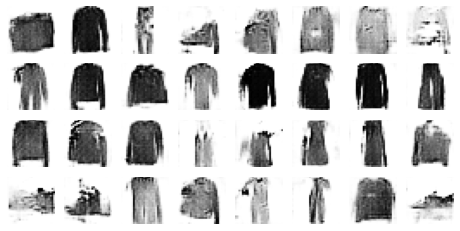

In [ ]:
# Note: takes a while to train!
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

1/1 [==============================] - 0s 197ms/step


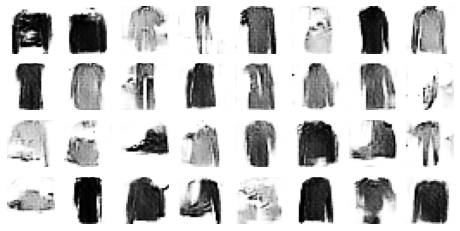

In [ ]:

# plot images from final model
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)

### Progressive Growing of GANs

One of the solutions for having more stable GAN models for larger images is to progressively increase number of the layers and image resolutions. The idea is to start by solving the simpler, lower-dimensionality problem, and then work your way up to higher-resolution images. This resembles greedy layer-wise training. 

First, you downsample the original images to produce a much lower resolution training dataset. Once you've trained your convolutional layers on these low-res images, you increase the resolution, and gradually add a new convolutional layer to both the generator and discriminator. This conv layer is typically in a forked path with a simple upscaling layer, and the two outputs are added together in a weighted combination with a weighting factor of $\alpha$. The value of $\alpha$ is initially zero, which means that the output will simply be equal to the output of the existing convolutional layer plus an up-pooling layer. We then slowly ramp up $\alpha$ from 0 to 1 during training, to gradually introduce the new convolutional layer. When $\alpha$ = 1, we have only a single path again, and all information flow will be through the new convolutional layer. If we didn't slowly 'mix' in the new conv layer this way, then the generator would suddenly start producing noisy outputs that would easily be identified as fake; this in turn would throw off training and detune the earlier layers. 

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Progressively-Adding-Layers-to-Generator-and-Discriminator-Models.png">

source: [Generate Large Images by Progressively Adding Layers, Jason Brownlee](https://machinelearningmastery.com/introduction-to-progressive-growing-generative-adversarial-networks)

### Conditional GAN

In our demo by training a GAN we managed to generate images from the MNIST dataset, however we did not have any control over the class (label) of the image that was produced ('shirt', 'shoe', etc.) [Conditional GANs](https://arxiv.org/pdf/1411.1784.pdf) solve this issue by bringing the labels into the system. The labels act as a helper to the discriminator, so that it can have a more guided decision to make. For example it can easily dismiss an image resembling '1' as fake, if the accompanying label is another digit, like '4'.

In CGANs both the fake and the real images are accompanied by labels. The label for the fake images is simply sampled from a uniform distribution over the set of labels. The labels are then given to both the Generator and Discriminator in a one-hot-encoding fashion, for example the label for '4' will be $(0, 0, 0, 0, 1, 0, 0, 0, 0, 0)$. The cost function is the same as regular GAN, except that the likelihoods are now conditioned on the label:

<center><img src="https://drive.google.com/uc?id=1bOxw_VJIwLoRhzWsrAKRPy_44ClCmEe3" ></center>

We do not have to stop there with the labels. For MNIST, we can add other labels besides the actual digit value, such as the size, style, thickness, and other attributes, and train a generator with richer set of capabilities for controlling these features in the output images.

### Info GAN

For the CGAN to work, we need to have access to a labeled training set. If we are not that lucky, we can still use a similar architecture as CGANs but ask the discriminator to help us extract the labels for us, and that is how the [InfoGANs](https://arxiv.org/pdf/1606.03657.pdf) work. As with CGANs, the generator is given a random one-hot encoded label $c$, along with the input noise of $z$. The generator $G(z, c)$ will output an image (in case of MNIST, a digit) which is then fed to the discriminator. Contrary to CGANs however, the discriminator not only has to determine the legitimacy of the image, it also has to guess the associated label for that image by producing a probability distribution $Q(c \mid x)$:

<center><img src="https://drive.google.com/uc?id=1yq1bDCKPMGuaq7Yt3ibG8wgR98rcJ4LO" ></center>


As an example, suppose that the discriminator outputs $Q=(0, 0.3, 0.7, \ldots)$ for a given image (fake or real). This means that the discriminator thinks that the input was a '1' with 0.3 probability and '2' with 0.7. 

We will not get into the mathematical details here but the cost function for InfoGAN is:

$$
\min _{G} \max _{D} V_{I n f G A N}(D, G)=V_{G A N}(D, G)-\lambda I(c ; G(z, c))
$$


The $I(c; G(z, c))$ term is subtracted from the original GAN loss. The $I(X;Y)$ is the __[Mutual Information](https://en.wikipedia.org/wiki/Mutual_information)__ between random variables $X$ and $Y$. This value measures how much we know about $X$ if we know $Y$. This value is close or equal to zero if $X$ and $Y$ are independent. Because the generator wants to minimize the loss function, it has to make the $\lambda I(c; G(z, c))$ term larger. As a result it will try to enforce a high mutual information between the latent code $c$ and its distribution $G(z, c)$. Intuitively, the choice of $c$ should have a bearing on the "style" of the generated image $G(z, c)$. Since maximizing the mutual information is hard in practice, an approximation of it is used instead, which we will not get into the details of here. The interested reader is encouraged to look at the original __[paper](https://arxiv.org/pdf/1606.03657.pdf)__. There, after training with the above method, the authors were able to generate MNIST digits and, by manipulating the latent code, change the type, rotation and the width of the generated digits:



<p>
    <figure>
    <center><img src="https://drive.google.com/uc?id=1-VNW4KpulI4lN3qhHiosxL3fM0N0JWKD" ></center>
        <figcaption><center>
            [<b>Image credit:</b> Chen, X., Duan, Y., Houthooft, R., Schulman, J., Sutskever, I., & Abbeel, P. (2016). </center><center>Infogan: Interpretable representation learning by information maximizing generative adversarial nets. </center><center>In Advances in neural information processing systems (pp. 2172-2180).]</center></figcaption>
</p>



### CycleGAN

Image-to-image translation is a class of vision and graphics problems where the goal is to learn the mapping between an input domain and an output domain using a training set of aligned image pairs. However, for many tasks, paired training data will not be available. CycleGAN is an approach for learning to translate an image from a source domain X to a target domain Y in the absence of paired examples. [source: https://junyanz.github.io/CycleGAN/]
<center><img src="https://drive.google.com/uc?id=1blnKoxOQz6gzFt-J07DiaRUIuSDI-7ou" ></center>


source: [Unpaired Image-to-Image Translationusing Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)

CycleGANs use a self-supervised technique that involves both an **adversarial loss** and a **reconstruction error** (a.k.a. **cycle consistency**) **loss**.

There are two pairs of generators and discriminators, one for each domain. 

First, images from Domain A are passed through a network resembling an auto-encoder, to attempt to map them to Domain B. The output images are then given to a discriminator, which compares them to real images from Domain B. In this way, the 'decoder' of the A -> B mapper learns how to map latent vectors to convincing "Domain B" images. Next, the synthesized images are mapped through a second network back to Domain A, where a second discriminator compares these outputs to real samples from Domain A. Lastly, since we converted an image from Domain A to Domain B and back to Domain A, we would expect the recovered image to be identical. So we apply a reconstruction loss. This encourages both of the A -> B and B -> A mapping networks to preserve semantic information about their inputs, as they perform their translations. 


A tutorial on implementing CycleGAN in TensorFlow is given here: https://www.tensorflow.org/tutorials/generative/cyclegan

### StyleGANs

StyleGANs were the state-of-the-art technique for image generation circa 2018. They use style transfer techniques in the generator to ensure the output images have the same local structure as the training images at every scale, leading to much better images at high resolutions. In this architecture, only the generator is different from what we've already seen. The discriminator and loss functions are the same as before.  

A StyleGAN generator consists of two parts: a Mapping Network, and a Synthesis Network. 

The Mapping Network, built from dense layers, turn a randomly-sampled latent vector "z" into multiple style vectors. It first produces a global style vector “w", which is then injected into each layer of the Synthesis Network through an affine transformation “A”. The affine transformation “A” is just a rotation and scaling of w, achieved using a dense layer without nonlinearity. The resulting transformed style vector will contribute two terms for each feature map in the layer: a scaling term and an offset term.

The Synthesis Network starts with a constant initial state (learned during training), followed by several convolution and upscaling layers. After each conv layer, we have a noise injection layer followed by an Adaptive Instance Normalization (AdaIN) layer. Each noise input is a single feature map full of Gaussian noise, scaled using per-feature scaling factors “B”, and added to all feature maps at that network level. The AdaIN layers at each level standardize each feature map independently, and then use the style vector to determine the scale and offset of each feature map. 

The idea of adding noise is very important. Some parts of an image are quite random, such as the exact position of each freckle or hair. In the earlier GAN architectures we discussed, the latent encoding itself would have needed to dedicate some of its representational power to storing this stochasticity, which seems like a waste of encoding space! Furthermore, the stochasticity would need to travel through each layer successively, slowing down training. StyleGAN avoids these problems by adding the right amount of stochasticity directly to each part of the image. 

Finally, StyleGAN uses a technique called "mixing regularization" to encourage locality, meaning each layer only affects a limited number of traits in the image. For more details, please consult the original paper: https://arxiv.org/pdf/1812.04948.pdf


<center><img src="https://drive.google.com/uc?id=1N9z9s5QTxPvXcczsvfA0XQMlGyFzrTtJ" ></center>
[source [A Style-Based Generator Architecture for Generative Adversarial Networks](https://arxiv.org/pdf/1812.04948.pdf)]

## Fully Visible Belief Nets (FVBN)

FVBNs are another approach you might come across, although today they seem overshadowed by GANs and related architectures. 

We'll continue to discuss image sampling problems here, but keep in mind that these techniques can also be applied to text synthesis, audio synthesis, and any such type of sequence synthesis. 

With images, FVBNs use the chain rule from calculus to decompose the density estimation $p(x)$ into a product of densities for individual pixels. The probability density of a single pixel is simply a 1-d distribution. However, as we saw in our Naive Bayes example from last week, the assumption of independence between pixels is a limiting assumption. Therefore, in FVBNs the density for each pixel $x_i$ is conditioned over all the pixel values that come before it: $p(x_i \mid x_1, x_2, \ldots, x_{i-1})$. So the likelihood of image $x$ is:

\begin{equation}
p(x) = \prod_{i=1}^{n} p(x_i \mid x_1, x_2, \ldots, x_{i-1})
\end{equation}

Given the above, we maximize the likelihood over our training data. 

The individual conditional distributions can be very complex in domains such as images. As we saw in last module's discussion of VAEs, we can model these complex distributions using neural networks, but we have to see what kind of neural network is well suited for this task. Also, we have to impose some ordering on the pixels, so that it is clear what we mean by a pixel coming *before* another in the above equation. Our choice of answers to the above questions lead to two architectures that we discuss briefly here: **PixelRNN** and **PixelCNN**.

### PixelRNN
[PixelRNN](https://arxiv.org/pdf/1601.06759.pdf) treats the image as a grid of pixels where each pixel value is conditioned on the value of its neighbors to the left and top: $x_{(i, j)} \mid x_{(i-1, j)}, x_{(i, j-1)}$. But then, each of these neighbours is also conditioned on their own neighbors to the left and to the top:

<center><img src="https://drive.google.com/uc?id=1INphPSVq4AVo7SnyD3A0IThVySaHuv0U" ></center>

Source [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf)


<p> Hence, we can see a sequence of these dependencies for any given pixel value, going back all the way to the initial pixels. As we saw in previous module, RNNs and in particular LSTMs are well-suited to capture these kind of sequential dependencies. We won't get into the technical model details here but using LSTMs and residual connections for faster convergence speed and more direct signal propagation through the network, we can use this model to generate synthetic samples. Here we see the result on CIFAR-10 and ImageNet 32x32:</p>

<br>
<figure>
  <center><img src="https://drive.google.com/uc?id=1pHMSIc-PA2yD_a7z90TLOSIry3nTk3r-" ></center>
    <figcaption>
        <center>Samples from models trained on CIFAR-10 (left) and ImageNet 32x32 (right) images.</center>
        <center>[<b>Image credit:</b> Van Den Oord, A., Dieleman, S., Zen, H., Simonyan, K., Vinyals, O., Graves, A., ... & Kavukcuoglu, K. (2016, September). WaveNet: A generative model for raw audio. In SSW (p. 125).]</center></figcaption>
</figure>

A technical observation is that the prediction values for the pixels are modeled as discrete values (due to some performance considerations) and are limited between 0 to 255 (for each of the 3 RGB channels). The distribution is modeled as a multinomial distribution and a softmax layer is used to capture that.

During training, the distributions over pixel values are calculated in parallel, however because of the recurrent networks that are used, the generation of the value is inherently sequential which makes image generation slow. Compare that to VAEs (and later with GANs) where pixels are generated in parallel. 

### PixelCNN
The *receptive field* of [PixelCNNs](https://arxiv.org/pdf/1606.05328.pdf) can go far back in the image and in theory, they can be unbounded so the state of each pixel has to be calculated sequentially. PixelCNN solves this problem by limiting the receptive field by using convolutional layers to bound the pixels that the current pixel is conditioned on:

<br>
<figure>
<center><img src="https://drive.google.com/uc?id=1k0mjf-ZA2ZSl540iW0JWPSqbQ0hxCNeW" ></center>
    <figcaption>
        <center> [<b>Image credit:</b> Oord, A. V. D., Kalchbrenner, N., Vinyals, O., Espeholt, L., Graves, A., & Kavukcuoglu, K. (2016, December). </center><center>Conditional image generation with pixelcnn decoders. In Proceedings of the 30th International Conference on Neural Information Processing Systems (pp. 4797-4805). Curran Associates Inc.]</center></figcaption>
</figure>

We can see that for any given pixel, a bounded neighborhood of it is mapped to predictions over the value of that pixel. Note that in this architecture, we are still conditioning the pixel value prediction on a large number of pixels. But this is no longer unbounded, as we can specify the size of the convolution. Also, the convolution that is used here is filtered (image on the right) so that the network does not peek into the values of the pixels that come after it in the sequence (strictly to the right and bellow).

The result is that during training PixelCNN is faster than PixelRNN, but image generation is still sequential, as the predicted value of a pixel is fed back into the network to predict the value of the pixels that come after it. So the generation is still slow.

Here are a few class-conditioned generated samples from the original paper:

<br>
<figure>
<center><img src="https://drive.google.com/uc?id=1-LWSd7tsuVwNEi0hGrUphYFIyrut2r49" ></center>
    <figcaption>
        <center> [<b>Image credit:</b> Oord et al. (2016, December). Conditional image generation with pixelcnn decoders. </center><center>In Proceedings of the 30th International Conference on Neural Information Processing Systems (pp. 4797-4805). Curran Associates Inc.]</center></figcaption>
</figure>

## Resources
1. FVBN:
    - [Pixel Recurrent Neural Networks By Logan Lebanoff](https://www.crcv.ucf.edu/wp-content/uploads/2019/03/CAP6412_Spring2018_Pixel-Recurrent-Neural-Networks.pdf)
    - [PixelRNN](https://arxiv.org/abs/1601.06759)
    - [PixelCNN](https://arxiv.org/abs/1606.05328)
    
    
    
2. GAN: 
    - [Stanford University CS230 - Lecture 4 (Winter 2019)](https://cs230.stanford.edu/lectures/2019/winter/4.pdf)
    - [WGAN](https://arxiv.org/pdf/1701.07875.pdf)
    - [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498.pdf)
    - [OpenAI Tutorial](https://blog.openai.com/generative-models/)
    - [GAN Lab: A greate visual source to learn GANs](https://poloclub.github.io/ganlab/)
    - [GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo)
    - [Introduction to GANs](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb)
    - [Ways to improve gans](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)
    - [A Style-Based Generator Architecture for Generative Adversarial Networks](https://www.youtube.com/watch?v=kSLJriaOumA&feature=youtu.be)
    - [Pixel to Pixel Demo](https://affinelayer.com/pixsrv/)
    - [Face to Ramen](https://www.youtube.com/watch?v=YGBzYsf61QY)
    - [Implementing CycleGAN Tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan)
    - [Info GAN](https://towardsdatascience.com/infogan-generative-adversarial-networks-part-iii-380c0c6712cd)
    - [DCGAN](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb)
    - [Adversarial Training](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture16.pdf)
    - [Visualizing and Understanding](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf)
    - [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/pdf/1703.06868.pdf)
    